In [109]:
import os
import subprocess
import numpy as np
import scipy as sp

import sys
import json
import time
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from metadata import *
from preprocess_utilities import *
from data_manager import DataManager
from registration_utilities import *

sys.path.append(os.path.join(os.environ['REPO_DIR'], '..', 'demo'))
from a_driver_utilities import *


In [110]:
stack = "MD585"
id_detector = 19
structure = "IC"

In [111]:
fixed_brain_spec_fp, moving_brain_spec_fp = make_structure_fixed_and_moving_brain_specs( stack, id_detector, structure)

In [112]:
brain_f_spec = load_json( fixed_brain_spec_fp )
brain_m_spec = load_json( moving_brain_spec_fp )

structures_f = brain_f_spec['structure']
if isinstance(structures_f, str):
    structures_f = [structures_f]
    
structures_m = brain_m_spec['structure']
if isinstance(structures_m, str):
    structures_m = [structures_m]
    
if brain_f_spec['vol_type'] == 'annotationAsScore': # If Neurolucida annotation
    fixed_surroundings_have_positive_value = True
    fixed_use_surround = True
elif brain_f_spec['vol_type'] == 'score': # If detection score map
    fixed_surroundings_have_positive_value = False
    fixed_use_surround = False
else:
    raise

print brain_m_spec
print brain_f_spec

{u'resolution': u'10.0um', u'name': u'atlasV7', u'structure': [u'IC'], u'vol_type': u'score'}
{u'detector_id': 19, u'resolution': u'10.0um', u'name': u'MD585', u'structure': [u'IC'], u'vol_type': u'score'}


In [113]:
registration_setting = 7
alignment_spec = dict(stack_m=brain_m_spec, stack_f=brain_f_spec, warp_setting=registration_setting)

aligner_parameters = generate_aligner_parameters_v2(alignment_spec=alignment_spec, 
                                                   structures_m=structures_m,
                                                   fixed_structures_are_sided=True,
                                                   fixed_surroundings_have_positive_value=fixed_surroundings_have_positive_value,
                                                   fixed_use_surround=fixed_use_surround)

upstream_warp_id                                                               None
transform_type                                                                rigid
grad_computation_sample_number                                               100000
grid_search_sample_number                                                      1000
std_tx_um                                                                        50
std_ty_um                                                                        50
std_tz_um                                                                        50
std_theta_xy_degree                                                              10
surround_weight                                                             inverse
regularization_weight                                                           NaN
terminate_thresh_trans                                                         0.01
terminate_thresh_rot                                                        

Prior structure/index map not found. Generating a new one.
Loaded moving volumes: [u'IC', u'IC_surround_200um'].
Prior structure/index map not found. Generating a new one.


loaded_cropbox_resolution 10.0um
voxel size for moving = 10.00 um
voxel size for fixed = 10.00 um
label_mapping_m2f {1: 1, 2: 1}
{1: -0.7810675793732089, 2: 1.0}


Loaded fixed volumes: [u'IC'].
Computing structure sizes: 0.14 s


In [114]:
from aligner_v3 import Aligner

aligner = Aligner(aligner_parameters['volume_fixed'], 
                  aligner_parameters['volume_moving'], 
                  labelIndexMap_m2f=aligner_parameters['label_mapping_m2f'])

aligner.compute_gradient(smooth_first=True)
aligner.set_label_weights(label_weights=aligner_parameters['label_weights_m'])

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
indices_f: set([1])


In [115]:
# Assumes simple_global already finished
T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = np.loadtxt(\
            os.path.join(DATA_ROOTDIR, 'CSHL_simple_global_registration', brain_f_spec['name'] + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.txt'))
aligner.set_initial_transform(T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol)
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m')


grid_search_T, _ = aligner.do_grid_search( grid_search_iteration_number=0, grid_search_sample_number=10, 
                       std_tx=100, std_ty=100, std_tz=30, 
                       grid_search_eta=3.0, 
                       stop_radius_voxel=10, indices_m=None, parallel=True, 
                       init_T=None)

Set initial transform to [ 9.95762842e-01  9.19691751e-02  2.97058176e-04  1.15774282e+03
 -9.19635605e-02  9.95728847e-01 -8.29580865e-03  4.97443355e+02
 -1.05874590e-03  8.23332256e-03  9.99965545e-01  4.66000000e+02].
centroid_m: [1122.92362702  256.73383846  464.01339887], centroid_f: [1122.92362702  256.73383846  464.01339887]


In [116]:
init_T = grid_search_T
aligner.set_initial_transform(init_T)
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m')

Set initial transform to [ 9.95762842e-01  9.19691751e-02  2.97058176e-04  1.15774282e+03
 -9.19635605e-02  9.95728847e-01 -8.29580865e-03  4.97443355e+02
 -1.05874590e-03  8.23332256e-03  9.99965545e-01  4.66000000e+02].
centroid_m: [1122.92362702  256.73383846  464.01339887], centroid_f: [1122.92362702  256.73383846  464.01339887]


In [117]:
_, _ = aligner.optimize(tf_type=aligner_parameters['transform_type'], 
                             max_iter_num=1000,
                             history_len=100, 
                             terminate_thresh_trans=.01,
                             terminate_thresh_rot=.01,
                             full_lr=np.array([1,1,1,.01,.01,.01]),
                            )

1: 2809527 valid, 587841 out-of-bound voxels after transform.
2: 8408297 valid, 1413499 out-of-bound voxels after transform.

iteration 0
1: 2809527 valid, 587841 out-of-bound voxels after transform.
2: 8408297 valid, 1413499 out-of-bound voxels after transform.
Norm of gradient (translation) = 1.732051
Norm of gradient (rotation) = 1.732051
around x=-0.57; around y=0.58; around z=0.57
step: 5.85 seconds
current score: -1.195918
new_T: [ 0.9999     -0.0100495   0.0099495   0.98996692  0.0099495   0.9999
  0.0100495   0.99993333 -0.0100495  -0.0099495   0.9999     -1.00996642]
det: 1.00

iteration 1
1: 2822550 valid, 574818 out-of-bound voxels after transform.
2: 8437837 valid, 1383959 out-of-bound voxels after transform.
Norm of gradient (translation) = 1.262350
Norm of gradient (rotation) = 1.250517
around x=-0.98; around y=0.98; around z=0.99
step: 5.90 seconds
current score: -1.130486
new_T: [ 0.99970412 -0.01757544  0.01681587  1.71356858  0.01728272  0.99969928
  0.01739698  1.744

2: 8756177 valid, 1065619 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.332581
Norm of gradient (rotation) = 0.376322
around x=-4.01; around y=3.93; around z=4.17
step: 6.21 seconds
current score: -0.582153
new_T: [ 0.99500086 -0.07735516  0.06316221  1.41985251  0.07258215  0.99456445
  0.07465515  7.34772746 -0.06859385 -0.06969749  0.99520709 -7.30975709]
det: 1.00

iteration 18
1: 2973321 valid, 424047 out-of-bound voxels after transform.
2: 8767491 valid, 1054305 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.321916
Norm of gradient (rotation) = 0.362238
around x=-4.12; around y=4.04; around z=4.30
step: 6.12 seconds
current score: -0.563715
new_T: [ 0.99470656 -0.07977857  0.064763    1.28222967  0.07473127  0.99423133
  0.07693701  7.56409313 -0.07052732 -0.07168993  0.99493037 -7.52724523]
det: 1.00

iteration 19
1: 2978951 valid, 418417 out-of-bound voxels after transform.
2: 8778316 valid, 1043480 out-of-bound voxels after tr

2: 8906665 valid, 915131 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.211793
Norm of gradient (rotation) = 0.211895
around x=-5.59; around y=5.43; around z=5.91
step: 6.23 seconds
current score: -0.345279
new_T: [  0.99022242  -0.11158692   0.08371334  -1.11540345   0.10244069
   0.98901332   0.10657657  10.31624497  -0.09468616  -0.09695886
   0.9907742  -10.34482657]
det: 1.00

iteration 36
1: 3052060 valid, 345308 out-of-bound voxels after transform.
2: 8912642 valid, 909154 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.206739
Norm of gradient (rotation) = 0.205931
around x=-5.65; around y=5.49; around z=5.98
step: 6.26 seconds
current score: -0.336532
new_T: [  0.98999337  -0.11303707   0.08447339  -1.24343408   0.1036863
   0.98873903   0.1079087   10.4379397   -0.09571982  -0.09807016
   0.99056547 -10.47206372]
det: 1.00

iteration 37
1: 3055051 valid, 342317 out-of-bound voxels after transform.
2: 8918453 valid, 903343 out-of

2: 8988200 valid, 833596 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.141530
Norm of gradient (rotation) = 0.134673
around x=-6.48; around y=6.22; around z=6.93
step: 6.31 seconds
current score: -0.232222
new_T: [  0.98684843  -0.13203917   0.09325146  -2.96448331   0.11995429
   0.98486778   0.12508566  12.0082859   -0.10835657  -0.11225468
   0.98775389 -12.13087537]
det: 1.00

iteration 53
1: 3090934 valid, 306434 out-of-bound voxels after transform.
2: 8991844 valid, 829952 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.138170
Norm of gradient (rotation) = 0.131362
around x=-6.52; around y=6.25; around z=6.98
step: 6.30 seconds
current score: -0.227360
new_T: [  0.98668225  -0.13301028   0.09362907  -3.05134634   0.1207859
   0.98465656   0.12594533  12.08760654  -0.1089445   -0.11295895
   0.98760892 -12.215294  ]
det: 1.00

iteration 54
1: 3092622 valid, 304746 out-of-bound voxels after transform.
2: 8995393 valid, 826403 out-of

2: 9036749 valid, 785047 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.095263
Norm of gradient (rotation) = 0.089048
around x=-7.06; around y=6.66; around z=7.64
step: 6.35 seconds
current score: -0.168747
new_T: [  0.98444172  -0.14601766   0.09774123  -4.14619013   0.13199199
   0.9817117    0.13718695  13.14825012  -0.11598542  -0.1221515
   0.98571111 -13.34520774]
det: 1.00

iteration 70
1: 3113881 valid, 283487 out-of-bound voxels after transform.
2: 9038893 valid, 782903 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.093353
Norm of gradient (rotation) = 0.086916
around x=-7.09; around y=6.68; around z=7.67
step: 6.42 seconds
current score: -0.165889
new_T: [  0.98432585  -0.14669505   0.09789374  -4.1991732    0.1325818
   0.98155281   0.13775393  13.20368777  -0.11629569  -0.12261583
   0.9856169  -13.40388689]
det: 1.00

iteration 71
1: 3114932 valid, 282436 out-of-bound voxels after transform.
2: 9040979 valid, 780817 out-of-

2: 9066911 valid, 754885 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.065995
Norm of gradient (rotation) = 0.060196
around x=-7.45; around y=6.87; around z=8.15
step: 6.31 seconds
current score: -0.129004
new_T: [  0.98279783  -0.1558728    0.09905603  -4.85166477   0.1406971
   0.97935481   0.14514983  13.96381211  -0.11963591  -0.12871604
   0.98443864 -14.19565819]
det: 1.00

iteration 87
1: 3128530 valid, 268838 out-of-bound voxels after transform.
2: 9068355 valid, 753441 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.064736
Norm of gradient (rotation) = 0.058915
around x=-7.47; around y=6.88; around z=8.17
step: 6.37 seconds
current score: -0.127115
new_T: [  0.98272091  -0.1563563    0.09905717  -4.88249583   0.14113369
   0.97923699   0.14552041  14.00460992  -0.11975348  -0.12902565
   0.98438381 -14.23695999]
det: 1.00

iteration 88
1: 3129242 valid, 268126 out-of-bound voxels after transform.
2: 9069782 valid, 752014 out-of

2: 9088407 valid, 733389 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.047178
Norm of gradient (rotation) = 0.043017
around x=-7.71; around y=6.92; around z=8.53
step: 6.64 seconds
current score: -0.099140
new_T: [  0.98173473  -0.16297053   0.09817093  -5.25532158   0.14725677
   0.97761234   0.15029824  14.57704409  -0.1204673   -0.13309667
   0.9837545  -14.79358978]
det: 1.00

iteration 104
1: 3138866 valid, 258502 out-of-bound voxels after transform.
2: 9089519 valid, 732277 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.046323
Norm of gradient (rotation) = 0.042305
around x=-7.72; around y=6.92; around z=8.55
step: 6.67 seconds
current score: -0.097526
new_T: [  0.98168675  -0.16332303   0.09806483  -5.27238431   0.14759323
   0.97752534   0.15053388  14.6085626   -0.1204465   -0.13330341
   0.98372905 -14.82253778]
det: 1.00

iteration 105
1: 3139386 valid, 257982 out-of-bound voxels after transform.
2: 9090604 valid, 731192 out

1: 3146425 valid, 250943 out-of-bound voxels after transform.
2: 9105611 valid, 716185 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.034888
Norm of gradient (rotation) = 0.034749
around x=-7.87; around y=6.85; around z=8.83
step: 6.44 seconds
current score: -0.072828
new_T: [  0.98109612  -0.16820799   0.09568943  -5.47259764   0.1524169
   0.97632133   0.1535114   15.06238876  -0.11924547  -0.13602476
   0.98350281 -15.20761368]
det: 1.00

iteration 121
1: 3146858 valid, 250510 out-of-bound voxels after transform.
2: 9106525 valid, 715271 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.034306
Norm of gradient (rotation) = 0.034487
around x=-7.88; around y=6.84; around z=8.85
step: 6.49 seconds
current score: -0.071335
new_T: [  0.981069    -0.16847208   0.09550276  -5.48124326   0.15268813
   0.97625652   0.15365395  15.08806233  -0.1191216   -0.13616299
   0.9834987  -15.22724579]
det: 1.00

iteration 122
1: 3147277 valid, 250091 out-

1: 3153244 valid, 244124 out-of-bound voxels after transform.
2: 9120551 valid, 701245 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.026827
Norm of gradient (rotation) = 0.032582
around x=-7.99; around y=6.69; around z=9.08
step: 6.35 seconds
current score: -0.047680
new_T: [  0.980758    -0.17218468   0.09201182  -5.57045825   0.1566579
   0.975353     0.15538606  15.46689678  -0.1164991   -0.13798174
   0.98355935 -15.48147037]
det: 1.00

iteration 138
1: 3153593 valid, 243775 out-of-bound voxels after transform.
2: 9121393 valid, 700403 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.026477
Norm of gradient (rotation) = 0.032584
around x=-7.99; around y=6.68; around z=9.09
step: 6.37 seconds
current score: -0.046240
new_T: [  0.98074527  -0.17238892   0.09176477  -5.57352772   0.15688623
   0.97530384   0.15546426  15.48889944  -0.11629884  -0.13807421
   0.98357008 -15.49389638]
det: 1.00

iteration 139
1: 3153966 valid, 243402 out-

2: 9134372 valid, 687424 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.021936
Norm of gradient (rotation) = 0.033570
around x=-8.06; around y=6.47; around z=9.28
step: 6.41 seconds
current score: -0.022633
new_T: [  0.98062396  -0.17531174   0.08742111  -5.59282673   0.1602994
   0.97460932   0.15633547  15.82148613  -0.11260887  -0.13929275
   0.98382761 -15.64426244]
det: 1.00

iteration 155
1: 3159618 valid, 237750 out-of-bound voxels after transform.
2: 9135161 valid, 686635 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.021727
Norm of gradient (rotation) = 0.033675
around x=-8.06; around y=6.45; around z=9.30
step: 6.41 seconds
current score: -0.021169
new_T: [  0.98062077  -0.1754757    0.08712742  -5.59236957   0.16049985
   0.97457094   0.15636905  15.84126266  -0.11235082  -0.1393548
   0.98384833 -15.65083507]
det: 1.00

iteration 156
1: 3159957 valid, 237411 out-of-bound voxels after transform.
2: 9135974 valid, 685822 out-o

2: 9147700 valid, 674096 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019410
Norm of gradient (rotation) = 0.035522
around x=-8.11; around y=6.19; around z=9.47
step: 6.64 seconds
current score: 0.002935
new_T: [  0.9806209   -0.17786823   0.08213125  -5.56774492   0.16355127
   0.97401943   0.15664334  16.14630545  -0.10785931  -0.14017507
   0.98423438 -15.71595175]
det: 1.00

iteration 172
1: 3165299 valid, 232069 out-of-bound voxels after transform.
2: 9148480 valid, 673316 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019323
Norm of gradient (rotation) = 0.035629
around x=-8.11; around y=6.17; around z=9.48
step: 6.58 seconds
current score: 0.004446
new_T: [  0.9806235   -0.17800528   0.08180263  -5.56528412   0.16373359
   0.97398835   0.15664614  16.16478551  -0.10755865  -0.14021705
   0.98426131 -15.7177023 ]
det: 1.00

iteration 173
1: 3165613 valid, 231755 out-of-bound voxels after transform.
2: 9149247 valid, 672549 out-o

2: 9160841 valid, 660955 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018633
Norm of gradient (rotation) = 0.037328
around x=-8.14; around y=5.88; around z=9.64
step: 6.42 seconds
current score: 0.028903
new_T: [  0.98069177  -0.18004593   0.07633549  -5.51218743   0.1665489
   0.97353245   0.15651207  16.45423869  -0.10249443  -0.14077651
   0.98472172 -15.71281264]
det: 1.00

iteration 189
1: 3170799 valid, 226569 out-of-bound voxels after transform.
2: 9161610 valid, 660186 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018630
Norm of gradient (rotation) = 0.037413
around x=-8.14; around y=5.86; around z=9.65
step: 6.46 seconds
current score: 0.030467
new_T: [  0.98069728  -0.18016528   0.07598236  -5.5082475    0.16671938
   0.97350618   0.15649396  16.4720218   -0.10216408  -0.14080547
   0.98475191 -15.71058222]
det: 1.00

iteration 190
1: 3171116 valid, 226252 out-of-bound voxels after transform.
2: 9162388 valid, 659408 out-of

2: 9173962 valid, 647834 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018878
Norm of gradient (rotation) = 0.038593
around x=-8.16; around y=5.55; around z=9.80
step: 6.44 seconds
current score: 0.055129
new_T: [  0.98079462  -0.18197298   0.07019793  -5.44004162   0.16937657
   0.97311337   0.15608317  16.75322178  -0.09671347  -0.14119565
   0.98524631 -15.64775423]
det: 1.00

iteration 206
1: 3176247 valid, 221121 out-of-bound voxels after transform.
2: 9174732 valid, 647064 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018909
Norm of gradient (rotation) = 0.038637
around x=-8.16; around y=5.53; around z=9.81
step: 6.41 seconds
current score: 0.056672
new_T: [  0.98080097  -0.18208049   0.06982951  -5.43546533   0.16953877
   0.97309028   0.156051    16.77063815  -0.09636426  -0.14121616
   0.98527759 -15.6422465 ]
det: 1.00

iteration 207
1: 3176569 valid, 220799 out-of-bound voxels after transform.
2: 9175495 valid, 646301 out-o

2: 9187050 valid, 634746 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019556
Norm of gradient (rotation) = 0.039105
around x=-8.17; around y=5.20; around z=9.95
step: 6.42 seconds
current score: 0.081223
new_T: [  0.98089866  -0.18373359   0.06387316  -5.36070985   0.17208208
   0.97273853   0.15545906  17.04762619  -0.09069494  -0.14149816
   0.98577518 -15.53260904]
det: 1.00

iteration 223
1: 3181654 valid, 215714 out-of-bound voxels after transform.
2: 9187814 valid, 633982 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019595
Norm of gradient (rotation) = 0.039118
around x=-8.17; around y=5.18; around z=9.96
step: 6.48 seconds
current score: 0.082725
new_T: [  0.98090433  -0.18383318   0.06349846  -5.35593804   0.17223795
   0.97271751   0.15541794  17.06484763  -0.09033704  -0.14151329
   0.98580587 -15.52452081]
det: 1.00

iteration 224
1: 3181965 valid, 215403 out-of-bound voxels after transform.
2: 9188587 valid, 633209 out-o

2: 9200157 valid, 621639 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020218
Norm of gradient (rotation) = 0.038868
around x=-8.18; around y=4.85; around z=10.10
step: 6.62 seconds
current score: 0.106938
new_T: [  0.98098291  -0.18537806   0.05751092  -5.28166895   0.1746848
   0.97239363   0.15471213  17.33904987  -0.08460348  -0.14172367
   0.98628426 -15.37903228]
det: 1.00

iteration 240
1: 3187001 valid, 210367 out-of-bound voxels after transform.
2: 9200932 valid, 620864 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020235
Norm of gradient (rotation) = 0.038821
around x=-8.18; around y=4.83; around z=10.11
step: 6.69 seconds
current score: 0.108426
new_T: [  0.98098696  -0.18547179   0.05713838  -5.27717742   0.17483477
   0.9723741    0.15466552  17.35609912  -0.08424597  -0.14173508
   0.98631323 -15.36903426]
det: 1.00

iteration 241
1: 3187313 valid, 210055 out-of-bound voxels after transform.
2: 9201689 valid, 620107 out-

2: 9213108 valid, 608688 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020635
Norm of gradient (rotation) = 0.037890
around x=-8.18; around y=4.51; around z=10.24
step: 6.52 seconds
current score: 0.131829
new_T: [  0.98103533  -0.18693229   0.05124443  -5.2065291    0.17718561
   0.97207115   0.15389261  17.62726946  -0.07858073  -0.14189431
   0.98675786 -15.19788671]
det: 1.00

iteration 257
1: 3192257 valid, 205111 out-of-bound voxels after transform.
2: 9213872 valid, 607924 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020659
Norm of gradient (rotation) = 0.037794
around x=-8.18; around y=4.49; around z=10.25
step: 6.48 seconds
current score: 0.133263
new_T: [  0.98103724  -0.18702138   0.05088167  -5.20219584   0.1773295
   0.97205274   0.15384316  17.64411097  -0.07823163  -0.14190305
   0.98678434 -15.18662486]
det: 1.00

iteration 258
1: 3192567 valid, 204801 out-of-bound voxels after transform.
2: 9214624 valid, 607172 out-

2: 9225849 valid, 595947 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020786
Norm of gradient (rotation) = 0.036416
around x=-8.19; around y=4.17; around z=10.37
step: 6.47 seconds
current score: 0.155577
new_T: [  0.98105099  -0.1884083    0.04518033  -5.13729731   0.17957765
   0.97176741   0.15303583  17.91124388  -0.07273799  -0.14202258
   0.9871873  -14.9985942 ]
det: 1.00

iteration 274
1: 3197381 valid, 199987 out-of-bound voxels after transform.
2: 9226593 valid, 595203 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020779
Norm of gradient (rotation) = 0.036304
around x=-8.19; around y=4.15; around z=10.38
step: 6.43 seconds
current score: 0.156953
new_T: [  0.98105077  -0.18849265   0.04483201  -5.13352688   0.1797146
   0.97175014   0.15298477  17.92777067  -0.07240201  -0.14202886
   0.9872111  -14.98650075]
det: 1.00

iteration 275
1: 3197662 valid, 199706 out-of-bound voxels after transform.
2: 9227323 valid, 594473 out-

2: 9238251 valid, 583545 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020618
Norm of gradient (rotation) = 0.034463
around x=-8.19; around y=3.85; around z=10.50
step: 6.51 seconds
current score: 0.178007
new_T: [  0.9810308   -0.18980494   0.03940373  -5.07493065   0.18184589
   0.97148263   0.15216296  18.18916007  -0.06716132  -0.14211114
   0.98756963 -14.78929793]
det: 1.00

iteration 291
1: 3202325 valid, 195043 out-of-bound voxels after transform.
2: 9238976 valid, 582820 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020573
Norm of gradient (rotation) = 0.034340
around x=-8.19; around y=3.83; around z=10.51
step: 6.52 seconds
current score: 0.179290
new_T: [  0.98102857  -0.18988449   0.03907462  -5.07149933   0.18197505
   0.97146652   0.15211143  18.20527125  -0.06684328  -0.14211506
   0.98759065 -14.77685602]
det: 1.00

iteration 292
1: 3202621 valid, 194747 out-of-bound voxels after transform.
2: 9239707 valid, 582089 out

1: 3206798 valid, 190570 out-of-bound voxels after transform.
2: 9250260 valid, 571536 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020046
Norm of gradient (rotation) = 0.032094
around x=-8.19; around y=3.55; around z=10.62
step: 6.50 seconds
current score: 0.198960
new_T: [  0.98097729  -0.19112283   0.03399451  -5.02113088   0.18397825
   0.97121668   0.15129492  18.45935742  -0.06193195  -0.14216263
   0.98790395 -14.57877492]
det: 1.00

iteration 308
1: 3207065 valid, 190303 out-of-bound voxels after transform.
2: 9250961 valid, 570835 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020001
Norm of gradient (rotation) = 0.031963
around x=-8.19; around y=3.53; around z=10.63
step: 6.65 seconds
current score: 0.200151
new_T: [  0.98097324  -0.19119771   0.03368879  -5.01820516   0.18409911
   0.97120169   0.15124418  18.47496997  -0.06163615  -0.14216442
   0.98792219 -14.56648657]
det: 1.00

iteration 309
1: 3207348 valid, 190020 out

2: 9261765 valid, 560031 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019241
Norm of gradient (rotation) = 0.029583
around x=-8.19; around y=3.27; around z=10.73
step: 6.45 seconds
current score: 0.218395
new_T: [  0.98089742  -0.1923532    0.02899128  -4.97566677   0.18596059
   0.97097232   0.15043741  18.72004883  -0.05708685  -0.14217243
   0.98819436 -14.37249011]
det: 1.00

iteration 325
1: 3211571 valid, 185797 out-of-bound voxels after transform.
2: 9262412 valid, 559384 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.019200
Norm of gradient (rotation) = 0.029445
around x=-8.19; around y=3.26; around z=10.74
step: 6.49 seconds
current score: 0.219498
new_T: [  0.98089199  -0.19242304   0.02871034  -4.97336112   0.1860726
   0.97095856   0.15038769  18.73508007  -0.05681461  -0.14217187
   0.98821013 -14.36061484]
det: 1.00

iteration 326
1: 3211825 valid, 185543 out-of-bound voxels after transform.
2: 9263068 valid, 558728 out-

2: 9272707 valid, 549089 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018307
Norm of gradient (rotation) = 0.027050
around x=-8.18; around y=3.02; around z=10.84
step: 6.46 seconds
current score: 0.236231
new_T: [  0.98079768  -0.19349394   0.02441308  -4.93680972   0.1877882
   0.9707505    0.1495963   18.97029986  -0.05264499  -0.14213922
   0.98844572 -14.17453498]
det: 1.00

iteration 342
1: 3215833 valid, 181535 out-of-bound voxels after transform.
2: 9273324 valid, 548472 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.018242
Norm of gradient (rotation) = 0.026915
around x=-8.18; around y=3.00; around z=10.84
step: 6.50 seconds
current score: 0.237233
new_T: [  0.98079141  -0.19355788   0.02415698  -4.93486433   0.18789055
   0.97073827   0.14954715  18.98465398  -0.05239613  -0.14213569
   0.98845945 -14.16319975]
det: 1.00

iteration 343
1: 3216082 valid, 181286 out-of-bound voxels after transform.
2: 9273966 valid, 547830 out-

2: 9283108 valid, 538688 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.017158
Norm of gradient (rotation) = 0.024402
around x=-8.18; around y=2.79; around z=10.93
step: 6.49 seconds
current score: 0.252637
new_T: [  0.98068591  -0.19453615   0.02026909  -4.90634814   0.18945154
   0.97055426   0.14877012  19.20876027  -0.04861342  -0.14205675
   0.98866406 -13.9882517 ]
det: 1.00

iteration 359
1: 3219866 valid, 177502 out-of-bound voxels after transform.
2: 9283693 valid, 538103 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.017097
Norm of gradient (rotation) = 0.024268
around x=-8.18; around y=2.77; around z=10.94
step: 6.48 seconds
current score: 0.253591
new_T: [  0.98067907  -0.19459446   0.02003909  -4.90484608   0.18954431
   0.9705435    0.14872212  19.22241279  -0.04838931  -0.14205037
   0.98867597 -13.9777393 ]
det: 1.00

iteration 360
1: 3220089 valid, 177279 out-of-bound voxels after transform.
2: 9284295 valid, 537501 out

Norm of gradient (translation) = 0.016018
Norm of gradient (rotation) = 0.021998
around x=-8.17; around y=2.59; around z=11.01
step: 6.46 seconds
current score: 0.266943
new_T: [ 9.80575310e-01 -1.95424808e-01  1.67691744e-02 -4.88290422e+00
  1.90864626e-01  9.70394131e-01  1.48006505e-01  1.94218283e+01
 -4.51968512e-02 -1.41930882e-01  9.88844209e-01 -1.38261963e+01]
det: 1.00

iteration 375
1: 3223458 valid, 173910 out-of-bound voxels after transform.
2: 9292909 valid, 528887 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.015943
Norm of gradient (rotation) = 0.021851
around x=-8.17; around y=2.58; around z=11.02
step: 6.52 seconds
current score: 0.267756
new_T: [ 9.80568343e-01 -1.95477345e-01  1.65629784e-02 -4.88170419e+00
  1.90948061e-01  9.70384927e-01  1.47959220e-01  1.94347725e+01
 -4.49951401e-02 -1.41921458e-01  9.88854760e-01 -1.38165186e+01]
det: 1.00

iteration 376
1: 3223676 valid, 173692 out-of-bound voxels after transform.
2: 9293472 valid, 

1: 3226628 valid, 170740 out-of-bound voxels after transform.
2: 9301064 valid, 520732 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.014828
Norm of gradient (rotation) = 0.019668
around x=-8.16; around y=2.41; around z=11.09
step: 6.59 seconds
current score: 0.279987
new_T: [ 9.80464506e-01 -1.96222431e-01  1.36422165e-02 -4.86524444e+00
  1.92130985e-01  9.70258565e-01  1.47254886e-01  1.96236218e+01
 -4.21311891e-02 -1.41757097e-01  9.89004494e-01 -1.36779056e+01]
det: 1.00

iteration 391
1: 3226830 valid, 170538 out-of-bound voxels after transform.
2: 9301588 valid, 520208 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.014747
Norm of gradient (rotation) = 0.019525
around x=-8.16; around y=2.40; around z=11.09
step: 6.50 seconds
current score: 0.280776
new_T: [ 9.80457731e-01 -1.96268928e-01  1.34590049e-02 -4.86395458e+00
  1.92204978e-01  9.70251030e-01  1.47207965e-01  1.96358317e+01
 -4.19509629e-02 -1.41744300e-01  9.89013989e-0

2: 9309260 valid, 512536 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.013608
Norm of gradient (rotation) = 0.017468
around x=-8.14; around y=2.26; around z=11.15
step: 6.49 seconds
current score: 0.292040
new_T: [ 9.80359068e-01 -1.96920886e-01  1.08748185e-02 -4.85151063e+00
  1.93245226e-01  9.70150687e-01  1.46505722e-01  1.98134103e+01
 -3.94002491e-02 -1.41526706e-01  9.89150045e-01 -1.35438508e+01]
det: 1.00

iteration 407
1: 3229963 valid, 167405 out-of-bound voxels after transform.
2: 9309746 valid, 512050 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.013540
Norm of gradient (rotation) = 0.017344
around x=-8.14; around y=2.25; around z=11.15
step: 6.50 seconds
current score: 0.292744
new_T: [ 9.80352723e-01 -1.96961329e-01  1.07132302e-02 -4.85081594e+00
  1.93309982e-01  9.70144838e-01  1.46459017e-01  1.98248825e+01
 -3.92401477e-02 -1.41510522e-01  9.89158725e-01 -1.35359445e+01]
det: 1.00

iteration 408
1: 3230165 valid, 

2: 9316946 valid, 504850 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.012416
Norm of gradient (rotation) = 0.015382
around x=-8.13; around y=2.12; around z=11.21
step: 6.55 seconds
current score: 0.303198
new_T: [ 9.80261881e-01 -1.97522873e-01  8.44744695e-03 -4.84113352e+00
  1.94213107e-01  9.70069912e-01  1.45758826e-01  1.99914561e+01
 -3.69853162e-02 -1.41241216e-01  9.89284087e-01 -1.34242952e+01]
det: 1.00

iteration 423
1: 3232873 valid, 164495 out-of-bound voxels after transform.
2: 9317471 valid, 504325 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.012335
Norm of gradient (rotation) = 0.015253
around x=-8.12; around y=2.11; around z=11.21
step: 6.54 seconds
current score: 0.303836
new_T: [ 9.80256130e-01 -1.97557375e-01  8.30681221e-03 -4.84062646e+00
  1.94268858e-01  9.70065751e-01  1.45712218e-01  2.00021995e+01
 -3.68446773e-02 -1.41221540e-01  9.89292144e-01 -1.34173182e+01]
det: 1.00

iteration 424
1: 3233097 valid, 

2: 9324150 valid, 497646 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.011330
Norm of gradient (rotation) = 0.013541
around x=-8.11; around y=2.00; around z=11.25
step: 6.52 seconds
current score: 0.313513
new_T: [ 9.80174791e-01 -1.98033306e-01  6.33944386e-03 -4.83767694e+00
  1.95042751e-01  9.70015092e-01  1.45013953e-01  2.01582373e+01
 -3.48669489e-02 -1.40902559e-01  9.89409301e-01 -1.33193006e+01]
det: 1.00

iteration 439
1: 3235680 valid, 161688 out-of-bound voxels after transform.
2: 9324582 valid, 497214 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.011243
Norm of gradient (rotation) = 0.013396
around x=-8.10; around y=1.99; around z=11.26
step: 6.49 seconds
current score: 0.314145
new_T: [ 9.80169699e-01 -1.98062369e-01  6.21759908e-03 -4.83757177e+00
  1.95090317e-01  9.70012465e-01  1.44967536e-01  2.01683095e+01
 -3.47437622e-02 -1.40879793e-01  9.89416876e-01 -1.33131969e+01]
det: 1.00

iteration 440
1: 3235857 valid, 

1: 3238113 valid, 159255 out-of-bound voxels after transform.
2: 9330884 valid, 490912 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.010257
Norm of gradient (rotation) = 0.011846
around x=-8.08; around y=1.89; around z=11.29
step: 6.74 seconds
current score: 0.323085
new_T: [ 9.80099861e-01 -1.98453589e-01  4.52058884e-03 -4.83339728e+00
  1.95740273e-01  9.69985924e-01  1.44267296e-01  2.03142028e+01
 -3.30152702e-02 -1.40511496e-01  9.89528429e-01 -1.32276191e+01]
det: 1.00

iteration 455
1: 3238268 valid, 159100 out-of-bound voxels after transform.
2: 9331288 valid, 490508 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.010205
Norm of gradient (rotation) = 0.011740
around x=-8.08; around y=1.89; around z=11.30
step: 6.58 seconds
current score: 0.323670
new_T: [ 9.80095617e-01 -1.98476903e-01  4.41587589e-03 -4.83374616e+00
  1.95779621e-01  9.69984948e-01  1.44220457e-01  2.03235947e+01
 -3.29077629e-02 -1.40485300e-01  9.89535729e-0

1: 3240565 valid, 156803 out-of-bound voxels after transform.
2: 9337212 valid, 484584 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.009211
Norm of gradient (rotation) = 0.010261
around x=-8.06; around y=1.80; around z=11.33
step: 6.57 seconds
current score: 0.331963
new_T: [ 9.80038730e-01 -1.98784390e-01  2.97546401e-03 -4.83157060e+00
  1.96308925e-01  9.69982481e-01  1.43515825e-01  2.04594662e+01
 -3.14148536e-02 -1.40066956e-01  9.89643549e-01 -1.31493446e+01]
det: 1.00

iteration 471
1: 3240714 valid, 156654 out-of-bound voxels after transform.
2: 9337593 valid, 484203 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.009154
Norm of gradient (rotation) = 0.010168
around x=-8.05; around y=1.79; around z=11.33
step: 6.56 seconds
current score: 0.332506
new_T: [ 9.80035373e-01 -1.98802237e-01  2.88750967e-03 -4.83187356e+00
  1.96340401e-01  9.69983078e-01  1.43468723e-01  2.04682017e+01
 -3.13227386e-02 -1.40037489e-01  9.89650639e-0

1: 3242859 valid, 154509 out-of-bound voxels after transform.
2: 9343142 valid, 478654 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.008231
Norm of gradient (rotation) = 0.008888
around x=-8.03; around y=1.72; around z=11.35
step: 6.53 seconds
current score: 0.340278
new_T: [ 9.79991699e-01 -1.99031217e-01  1.68661860e-03 -4.83100545e+00
  1.96756907e-01  9.70003203e-01  1.42760311e-01  2.05946049e+01
 -3.00497838e-02 -1.39572065e-01  9.89755853e-01 -1.30843372e+01]
det: 1.00

iteration 487
1: 3242998 valid, 154370 out-of-bound voxels after transform.
2: 9343496 valid, 478300 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.008184
Norm of gradient (rotation) = 0.008809
around x=-8.02; around y=1.72; around z=11.35
step: 6.59 seconds
current score: 0.340791
new_T: [ 9.79989273e-01 -1.99043766e-01  1.61392750e-03 -4.83113763e+00
  1.96780915e-01  9.70005330e-01  1.42712757e-01  2.06027158e+01
 -2.99716028e-02 -1.39539381e-01  9.89762832e-0

2: 9348697 valid, 473099 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.007376
Norm of gradient (rotation) = 0.007750
around x=-7.99; around y=1.66; around z=11.37
step: 6.77 seconds
current score: 0.348095
new_T: [ 9.79959534e-01 -1.99195685e-01  6.25476817e-04 -4.83354277e+00
  1.97090292e-01  9.70047748e-01  1.41995714e-01  2.07200973e+01
 -2.88916758e-02 -1.39026778e-01  9.89867075e-01 -1.30313137e+01]
det: 1.00

iteration 503
1: 3245150 valid, 152218 out-of-bound voxels after transform.
2: 9349029 valid, 472767 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.007331
Norm of gradient (rotation) = 0.007693
around x=-7.99; around y=1.65; around z=11.37
step: 6.60 seconds
current score: 0.348538
new_T: [ 9.79958014e-01 -1.99203339e-01  5.66346697e-04 -4.83345039e+00
  1.97107490e-01  9.70051292e-01  1.41947626e-01  2.07276365e+01
 -2.88258265e-02 -1.38991083e-01  9.89874007e-01 -1.30283776e+01]
det: 1.00

iteration 504
1: 3245283 valid, 

1: 3247060 valid, 150308 out-of-bound voxels after transform.
2: 9353901 valid, 467895 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.006673
Norm of gradient (rotation) = 0.006867
around x=-7.96; around y=1.60; around z=11.38
step: 6.62 seconds
current score: 0.355327
new_T: [ 9.79942223e-01 -1.99281676e-01 -2.29862610e-04 -4.83721654e+00
  1.97316326e-01  9.70114972e-01  1.41220429e-01  2.08365156e+01
 -2.79196507e-02 -1.38433217e-01  9.89978150e-01 -1.29892766e+01]
det: 1.00

iteration 519
1: 3247187 valid, 150181 out-of-bound voxels after transform.
2: 9354219 valid, 467577 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.006589
Norm of gradient (rotation) = 0.006832
around x=-7.96; around y=1.60; around z=11.39
step: 6.57 seconds
current score: 0.355765
new_T: [ 9.79941618e-01 -1.99284593e-01 -2.77047337e-04 -4.83733601e+00
  1.97327120e-01  9.70119882e-01  1.41171603e-01  2.08435094e+01
 -2.78645562e-02 -1.38394598e-01  9.89985102e-0

2: 9358807 valid, 462989 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.006025
Norm of gradient (rotation) = 0.006200
around x=-7.92; around y=1.55; around z=11.39
step: 6.51 seconds
current score: 0.362269
new_T: [ 9.79938935e-01 -1.99295931e-01 -9.03393984e-04 -4.84291486e+00
  1.97445295e-01  9.70202765e-01  1.40434862e-01  2.09446924e+01
 -2.71116212e-02 -1.37795960e-01  9.90089508e-01 -1.29572856e+01]
det: 1.00

iteration 535
1: 3249114 valid, 148254 out-of-bound voxels after transform.
2: 9359108 valid, 462688 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005979
Norm of gradient (rotation) = 0.006167
around x=-7.92; around y=1.55; around z=11.39
step: 6.57 seconds
current score: 0.362695
new_T: [ 9.79939169e-01 -1.99294610e-01 -9.39695318e-04 -4.84327538e+00
  1.97450338e-01  9.70208880e-01  1.40385517e-01  2.09511976e+01
 -2.70663760e-02 -1.37754810e-01  9.90096472e-01 -1.29556188e+01]
det: 1.00

iteration 536
1: 3249231 valid, 

1: 3250818 valid, 146550 out-of-bound voxels after transform.
2: 9363424 valid, 458372 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005453
Norm of gradient (rotation) = 0.005757
around x=-7.88; around y=1.52; around z=11.39
step: 6.55 seconds
current score: 0.368817
new_T: [ 9.79948993e-01 -1.99243520e-01 -1.41079008e-03 -4.84877076e+00
  1.97484649e-01  9.70309501e-01  1.39639843e-01  2.10452659e+01
 -2.64534308e-02 -1.37118533e-01  9.90201355e-01 -1.29347196e+01]
det: 1.00

iteration 551
1: 3250928 valid, 146440 out-of-bound voxels after transform.
2: 9363706 valid, 458090 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005427
Norm of gradient (rotation) = 0.005747
around x=-7.88; around y=1.51; around z=11.39
step: 6.57 seconds
current score: 0.369237
new_T: [ 9.79950059e-01 -1.99238086e-01 -1.43751837e-03 -4.84904381e+00
  1.97484269e-01  9.70316784e-01  1.39589767e-01  2.10513111e+01
 -2.64167497e-02 -1.37074887e-01  9.90208377e-0

1: 3252564 valid, 144804 out-of-bound voxels after transform.
2: 9367785 valid, 454011 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005023
Norm of gradient (rotation) = 0.005531
around x=-7.84; around y=1.49; around z=11.39
step: 6.57 seconds
current score: 0.375052
new_T: [ 9.79971957e-01 -1.99127632e-01 -1.77478256e-03 -4.85284665e+00
  1.97441014e-01  9.70434173e-01  1.38832859e-01  2.11387817e+01
 -2.59231488e-02 -1.36402723e-01  9.90314237e-01 -1.29203380e+01]
det: 1.00

iteration 567
1: 3252664 valid, 144704 out-of-bound voxels after transform.
2: 9368050 valid, 453746 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004978
Norm of gradient (rotation) = 0.005525
around x=-7.84; around y=1.48; around z=11.39
step: 6.55 seconds
current score: 0.375396
new_T: [ 9.79973793e-01 -1.99118432e-01 -1.79305160e-03 -4.85304394e+00
  1.97435724e-01  9.70442513e-01  1.38782075e-01  2.11444070e+01
 -2.58940158e-02 -1.36356809e-01  9.90321322e-0

2: 9371919 valid, 449877 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004701
Norm of gradient (rotation) = 0.005441
around x=-7.80; around y=1.46; around z=11.38
step: 6.51 seconds
current score: 0.381013
new_T: [ 9.80006521e-01 -1.98955229e-01 -2.00886257e-03 -4.85795690e+00
  1.97323315e-01  9.70574538e-01  1.38016577e-01  2.12259306e+01
 -2.55093688e-02 -1.35653541e-01  9.90427882e-01 -1.29138306e+01]
det: 1.00

iteration 583
1: 3254330 valid, 143038 out-of-bound voxels after transform.
2: 9372172 valid, 449624 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004665
Norm of gradient (rotation) = 0.005438
around x=-7.80; around y=1.46; around z=11.38
step: 6.52 seconds
current score: 0.381372
new_T: [ 9.80009044e-01 -1.98942694e-01 -2.01941208e-03 -4.85826751e+00
  1.97313652e-01  9.70583793e-01  1.37965300e-01  2.12311792e+01
 -2.54871798e-02 -1.35605699e-01  9.90435004e-01 -1.29136769e+01]
det: 1.00

iteration 584
1: 3254429 valid, 

2: 9375838 valid, 445958 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004460
Norm of gradient (rotation) = 0.005474
around x=-7.75; around y=1.44; around z=11.37
step: 6.55 seconds
current score: 0.386685
new_T: [ 9.80051730e-01 -1.98731212e-01 -2.12420727e-03 -4.86373972e+00
  1.97138140e-01  9.70728992e-01  1.37192483e-01  2.13072683e+01
 -2.52023988e-02 -1.34874492e-01  9.90542130e-01 -1.29147919e+01]
det: 1.00

iteration 599
1: 3255910 valid, 141458 out-of-bound voxels after transform.
2: 9376075 valid, 445721 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004448
Norm of gradient (rotation) = 0.005481
around x=-7.75; around y=1.44; around z=11.37
step: 6.54 seconds
current score: 0.387025
new_T: [ 9.80054888e-01 -1.98715596e-01 -2.12792349e-03 -4.86414308e+00
  1.97124491e-01  9.70739082e-01  1.37140696e-01  2.13121732e+01
 -2.51863368e-02 -1.34824876e-01  9.90549293e-01 -1.29150744e+01]
det: 1.00

iteration 600
1: 3256002 valid, 

2: 9379555 valid, 442241 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004319
Norm of gradient (rotation) = 0.005603
around x=-7.71; around y=1.43; around z=11.36
step: 6.52 seconds
current score: 0.392172
new_T: [ 9.80106874e-01 -1.98458948e-01 -2.13577244e-03 -4.87024373e+00
  1.96891095e-01  9.70896421e-01  1.36359951e-01  2.13832727e+01
 -2.49882386e-02 -1.34067840e-01  9.90657056e-01 -1.29224934e+01]
det: 1.00

iteration 615
1: 3257426 valid, 139942 out-of-bound voxels after transform.
2: 9379785 valid, 442011 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004302
Norm of gradient (rotation) = 0.005620
around x=-7.70; around y=1.43; around z=11.36
step: 6.58 seconds
current score: 0.392515
new_T: [ 9.80110638e-01 -1.98440387e-01 -2.13325731e-03 -4.87066256e+00
  1.96873691e-01  9.70907296e-01  1.36307637e-01  2.13878530e+01
 -2.49777451e-02 -1.34016547e-01  9.90664261e-01 -1.29231932e+01]
det: 1.00

iteration 616
1: 3257518 valid, 

1: 3258796 valid, 138572 out-of-bound voxels after transform.
2: 9383107 valid, 438689 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004244
Norm of gradient (rotation) = 0.005793
around x=-7.66; around y=1.42; around z=11.34
step: 6.90 seconds
current score: 0.397414
new_T: [ 9.80171271e-01 -1.98141506e-01 -2.05504456e-03 -4.87687627e+00
  1.96586978e-01  9.71075744e-01  1.35519223e-01  2.14543370e+01
 -2.48563789e-02 -1.33236044e-01  9.90772586e-01 -1.29364639e+01]
det: 1.00

iteration 631
1: 3258886 valid, 138482 out-of-bound voxels after transform.
2: 9383327 valid, 438469 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004252
Norm of gradient (rotation) = 0.005803
around x=-7.66; around y=1.42; around z=11.34
step: 6.75 seconds
current score: 0.397753
new_T: [ 9.80175568e-01 -1.98120330e-01 -2.04725684e-03 -4.87738542e+00
  1.96566285e-01  9.71087294e-01  1.35466464e-01  2.14586317e+01
 -2.48505954e-02 -1.33183340e-01  9.90779817e-0

2: 9386487 valid, 435309 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004180
Norm of gradient (rotation) = 0.006011
around x=-7.61; around y=1.42; around z=11.32
step: 6.52 seconds
current score: 0.402450
new_T: [ 9.80243868e-01 -1.97783617e-01 -1.89734008e-03 -4.88254824e+00
  1.96232705e-01  9.71265427e-01  1.34670697e-01  2.15210748e+01
 -2.47928368e-02 -1.32382445e-01  9.90888593e-01 -1.29558108e+01]
det: 1.00

iteration 647
1: 3260282 valid, 137086 out-of-bound voxels after transform.
2: 9386692 valid, 435104 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004180
Norm of gradient (rotation) = 0.006026
around x=-7.61; around y=1.42; around z=11.32
step: 6.58 seconds
current score: 0.402761
new_T: [ 9.80248667e-01 -1.97759948e-01 -1.88527882e-03 -4.88286112e+00
  1.96208991e-01  9.71277612e-01  1.34617356e-01  2.15251108e+01
 -2.47907922e-02 -1.32328392e-01  9.90895864e-01 -1.29571756e+01]
det: 1.00

iteration 648
1: 3260367 valid, 

1: 3261557 valid, 135811 out-of-bound voxels after transform.
2: 9389713 valid, 432083 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004201
Norm of gradient (rotation) = 0.006230
around x=-7.56; around y=1.42; around z=11.30
step: 7.16 seconds
current score: 0.407334
new_T: [ 9.80323996e-01 -1.97388076e-01 -1.67653749e-03 -4.88691137e+00
  1.95833071e-01  9.71464533e-01  1.33813565e-01  2.15839051e+01
 -2.47845053e-02 -1.31508970e-01  9.91005106e-01 -1.29796932e+01]
det: 1.00

iteration 663
1: 3261639 valid, 135729 out-of-bound voxels after transform.
2: 9389911 valid, 431885 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004202
Norm of gradient (rotation) = 0.006249
around x=-7.56; around y=1.42; around z=11.30
step: 6.92 seconds
current score: 0.407633
new_T: [ 9.80329237e-01 -1.97362178e-01 -1.66071011e-03 -4.88723554e+00
  1.95806673e-01  9.71477268e-01  1.33759728e-01  2.15877079e+01
 -2.47857692e-02 -1.31453750e-01  9.91012400e-0

2: 9392823 valid, 428973 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004282
Norm of gradient (rotation) = 0.006443
around x=-7.51; around y=1.42; around z=11.27
step: 6.60 seconds
current score: 0.412088
new_T: [ 9.80410850e-01 -1.96958397e-01 -1.39822117e-03 -4.89259691e+00
  1.95392408e-01  9.71671923e-01  1.32949167e-01  2.16431472e+01
 -2.48268425e-02 -1.30618008e-01  9.91121871e-01 -1.30080200e+01]
det: 1.00

iteration 679
1: 3262964 valid, 134404 out-of-bound voxels after transform.
2: 9393010 valid, 428786 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004267
Norm of gradient (rotation) = 0.006459
around x=-7.50; around y=1.42; around z=11.27
step: 6.60 seconds
current score: 0.412359
new_T: [ 9.80416477e-01 -1.96930518e-01 -1.37908539e-03 -4.89297506e+00
  1.95363636e-01  9.71685125e-01  1.32894953e-01  2.16467426e+01
 -2.48310351e-02 -1.30561824e-01  9.91129169e-01 -1.30099265e+01]
det: 1.00

iteration 680
1: 3263041 valid, 

1: 3264172 valid, 133196 out-of-bound voxels after transform.
2: 9395824 valid, 425972 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004344
Norm of gradient (rotation) = 0.006639
around x=-7.46; around y=1.43; around z=11.24
step: 6.62 seconds
current score: 0.416784
new_T: [ 9.80503474e-01 -1.96498840e-01 -1.06963195e-03 -4.89870820e+00
  1.94915973e-01  9.71886205e-01  1.32079398e-01  2.16992851e+01
 -2.49138879e-02 -1.29712797e-01  9.91238563e-01 -1.30402708e+01]
det: 1.00

iteration 695
1: 3264250 valid, 133118 out-of-bound voxels after transform.
2: 9396015 valid, 425781 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004319
Norm of gradient (rotation) = 0.006650
around x=-7.45; around y=1.43; around z=11.24
step: 6.62 seconds
current score: 0.417089
new_T: [ 9.80509434e-01 -1.96469212e-01 -1.04777366e-03 -4.89902972e+00
  1.94885141e-01  9.71899798e-01  1.32024863e-01  2.17027038e+01
 -2.49204898e-02 -1.29655819e-01  9.91245851e-0

1: 3265396 valid, 131972 out-of-bound voxels after transform.
2: 9398731 valid, 423065 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004361
Norm of gradient (rotation) = 0.006823
around x=-7.40; around y=1.43; around z=11.21
step: 6.59 seconds
current score: 0.421320
new_T: [ 9.80601270e-01 -1.96011875e-01 -7.02502401e-04 -4.90303637e+00
  1.94407862e-01  9.72106540e-01  1.31203879e-01  2.17526894e+01
 -2.50346111e-02 -1.28795262e-01  9.91355158e-01 -1.30756753e+01]
det: 1.00

iteration 711
1: 3265472 valid, 131896 out-of-bound voxels after transform.
2: 9398916 valid, 422880 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004381
Norm of gradient (rotation) = 0.006830
around x=-7.40; around y=1.44; around z=11.21
step: 6.58 seconds
current score: 0.421612
new_T: [ 9.80607550e-01 -1.95980540e-01 -6.78650238e-04 -4.90336834e+00
  1.94375115e-01  9.72120503e-01  1.31148929e-01  2.17559395e+01
 -2.50429081e-02 -1.28737543e-01  9.91362445e-0

2: 9401558 valid, 420238 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004441
Norm of gradient (rotation) = 0.006977
around x=-7.35; around y=1.44; around z=11.18
step: 6.65 seconds
current score: 0.425725
new_T: [ 9.80703676e-01 -1.95499890e-01 -3.05292500e-04 -4.90727524e+00
  1.93871609e-01  9.72332073e-01  1.30323211e-01  2.18036042e+01
 -2.51813277e-02 -1.27867640e-01  9.91471516e-01 -1.31139123e+01]
det: 1.00

iteration 727
1: 3266644 valid, 130724 out-of-bound voxels after transform.
2: 9401734 valid, 420062 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004455
Norm of gradient (rotation) = 0.006976
around x=-7.35; around y=1.44; around z=11.18
step: 6.61 seconds
current score: 0.425990
new_T: [ 9.80710202e-01 -1.95467186e-01 -2.79602075e-04 -4.90754752e+00
  1.93837301e-01  9.72346302e-01  1.30268069e-01  2.18067175e+01
 -2.51912628e-02 -1.27809421e-01  9.91478770e-01 -1.31163853e+01]
det: 1.00

iteration 728
1: 3266714 valid, 

2: 9404274 valid, 417522 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004559
Norm of gradient (rotation) = 0.007110
around x=-7.29; around y=1.45; around z=11.15
step: 6.65 seconds
current score: 0.430045
new_T: [ 9.80809954e-01 -1.94966204e-01  1.17162501e-04 -4.91237644e+00
  1.93311151e-01  9.72561722e-01  1.29439159e-01  2.18524108e+01
 -2.53502091e-02 -1.26932566e-01  9.91587359e-01 -1.31545835e+01]
det: 1.00

iteration 743
1: 3267886 valid, 129482 out-of-bound voxels after transform.
2: 9404457 valid, 417339 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004527
Norm of gradient (rotation) = 0.007120
around x=-7.29; around y=1.45; around z=11.15
step: 6.64 seconds
current score: 0.430362
new_T: [ 9.80816723e-01 -1.94932131e-01  1.44520953e-04 -4.91256908e+00
  1.93275308e-01  9.72576209e-01  1.29383824e-01  2.18553910e+01
 -2.53616222e-02 -1.26873886e-01  9.91594577e-01 -1.31572182e+01]
det: 1.00

iteration 744
1: 3267933 valid, 

2: 9406939 valid, 414857 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004593
Norm of gradient (rotation) = 0.007231
around x=-7.24; around y=1.46; around z=11.12
step: 6.57 seconds
current score: 0.434318
new_T: [ 9.80919668e-01 -1.94412674e-01  5.64064722e-04 -4.91670578e+00
  1.92728463e-01  9.72794874e-01  1.28552997e-01  2.18992752e+01
 -2.55410512e-02 -1.25991452e-01  9.91702480e-01 -1.31978677e+01]
det: 1.00

iteration 759
1: 3269005 valid, 128363 out-of-bound voxels after transform.
2: 9407101 valid, 414695 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004553
Norm of gradient (rotation) = 0.007235
around x=-7.24; around y=1.46; around z=11.11
step: 6.60 seconds
current score: 0.434602
new_T: [ 9.80926643e-01 -1.94377392e-01  5.92509651e-04 -4.91655307e+00
  1.92691321e-01  9.72809568e-01  1.28497470e-01  2.19021446e+01
 -2.55534022e-02 -1.25932420e-01  9.91709660e-01 -1.32006266e+01]
det: 1.00

iteration 760
1: 3269072 valid, 

1: 3270062 valid, 127306 out-of-bound voxels after transform.
2: 9409522 valid, 412274 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004641
Norm of gradient (rotation) = 0.007343
around x=-7.19; around y=1.48; around z=11.08
step: 6.99 seconds
current score: 0.438473
new_T: [ 9.81032880e-01 -1.93838685e-01  1.02623139e-03 -4.91874021e+00
  1.92124202e-01  9.73031626e-01  1.27662627e-01  2.19442670e+01
 -2.57445114e-02 -1.25044071e-01  9.91817120e-01 -1.32429952e+01]
det: 1.00

iteration 775
1: 3270128 valid, 127240 out-of-bound voxels after transform.
2: 9409682 valid, 412114 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004646
Norm of gradient (rotation) = 0.007349
around x=-7.18; around y=1.48; around z=11.08
step: 6.71 seconds
current score: 0.438743
new_T: [ 9.81040061e-01 -1.93802180e-01  1.05553108e-03 -4.91884760e+00
  1.92085780e-01  9.73046529e-01  1.27606843e-01  2.19470219e+01
 -2.57575652e-02 -1.24984673e-01  9.91824268e-0

1: 3271167 valid, 126201 out-of-bound voxels after transform.
2: 9412044 valid, 409752 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004737
Norm of gradient (rotation) = 0.007417
around x=-7.13; around y=1.49; around z=11.04
step: 6.78 seconds
current score: 0.442550
new_T: [ 9.81148829e-01 -1.93247820e-01  1.50172271e-03 -4.92273400e+00
  1.91502152e-01  9.73270930e-01  1.26769963e-01  2.19876897e+01
 -2.59596020e-02 -1.24092618e-01  9.91931006e-01 -1.32898695e+01]
det: 1.00

iteration 791
1: 3271236 valid, 126132 out-of-bound voxels after transform.
2: 9412204 valid, 409592 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004783
Norm of gradient (rotation) = 0.007416
around x=-7.13; around y=1.49; around z=11.04
step: 6.67 seconds
current score: 0.442821
new_T: [ 9.81156138e-01 -1.93210471e-01  1.53168837e-03 -4.92319250e+00
  1.91462845e-01  9.73285925e-01  1.26714192e-01  2.19903639e+01
 -2.59732794e-02 -1.24033146e-01  9.91938087e-0

2: 9414532 valid, 407264 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004827
Norm of gradient (rotation) = 0.007463
around x=-7.08; around y=1.50; around z=11.01
step: 6.69 seconds
current score: 0.446604
new_T: [ 9.81266373e-01 -1.92645671e-01  1.98778999e-03 -4.92666059e+00
  1.90868123e-01  9.73511063e-01  1.25879184e-01  2.20300276e+01
 -2.61852154e-02 -1.23141604e-01  9.92043588e-01 -1.33384864e+01]
det: 1.00

iteration 807
1: 3272319 valid, 125049 out-of-bound voxels after transform.
2: 9414678 valid, 407118 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004791
Norm of gradient (rotation) = 0.007471
around x=-7.07; around y=1.50; around z=11.00
step: 6.67 seconds
current score: 0.446844
new_T: [ 9.81273774e-01 -1.92607649e-01  2.01850606e-03 -4.92671522e+00
  1.90828089e-01  9.73526106e-01  1.25823533e-01  2.20326388e+01
 -2.61996434e-02 -1.23082146e-01  9.92050585e-01 -1.33415751e+01]
det: 1.00

iteration 808
1: 3272392 valid, 

2: 9416961 valid, 404835 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004873
Norm of gradient (rotation) = 0.007512
around x=-7.02; around y=1.51; around z=10.97
step: 6.60 seconds
current score: 0.450589
new_T: [ 9.81385479e-01 -1.92032233e-01  2.48255014e-03 -4.92903434e+00
  1.90222395e-01  9.73752087e-01  1.24989254e-01  2.20713328e+01
 -2.64193540e-02 -1.22190402e-01  9.92154990e-01 -1.33886318e+01]
det: 1.00

iteration 823
1: 3273391 valid, 123977 out-of-bound voxels after transform.
2: 9417110 valid, 404686 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004850
Norm of gradient (rotation) = 0.007512
around x=-7.02; around y=1.51; around z=10.97
step: 6.66 seconds
current score: 0.450847
new_T: [ 9.81392973e-01 -1.91993527e-01  2.51351557e-03 -4.92913828e+00
  1.90181687e-01  9.73767175e-01  1.24933641e-01  2.20738836e+01
 -2.64340292e-02 -1.22130972e-01  9.92161916e-01 -1.33917971e+01]
det: 1.00

iteration 824
1: 3273459 valid, 

2: 9419354 valid, 402442 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004925
Norm of gradient (rotation) = 0.007556
around x=-6.97; around y=1.53; around z=10.93
step: 6.59 seconds
current score: 0.454526
new_T: [ 9.81506118e-01 -1.91407564e-01  2.98065922e-03 -4.93136113e+00
  1.89565715e-01  9.73993940e-01  1.24099334e-01  2.21116653e+01
 -2.66566951e-02 -1.21239225e-01  9.92265323e-01 -1.34399239e+01]
det: 1.00

iteration 839
1: 3274443 valid, 122925 out-of-bound voxels after transform.
2: 9419495 valid, 402301 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004917
Norm of gradient (rotation) = 0.007558
around x=-6.96; around y=1.53; around z=10.93
step: 6.59 seconds
current score: 0.454771
new_T: [ 9.81513710e-01 -1.91368144e-01  3.01179755e-03 -4.93158309e+00
  1.89524317e-01  9.74009085e-01  1.24043682e-01  2.21141545e+01
 -2.66715274e-02 -1.21179766e-01  9.92272187e-01 -1.34431579e+01]
det: 1.00

iteration 840
1: 3274510 valid, 

1: 3275408 valid, 121960 out-of-bound voxels after transform.
2: 9421697 valid, 400099 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004938
Norm of gradient (rotation) = 0.007571
around x=-6.91; around y=1.54; around z=10.89
step: 6.66 seconds
current score: 0.458363
new_T: [ 9.81628095e-01 -1.90772590e-01  3.47870128e-03 -4.93457849e+00
  1.88899407e-01  9.74236266e-01  1.23210035e-01  2.21511300e+01
 -2.68941744e-02 -1.20289307e-01  9.92374519e-01 -1.34921568e+01]
det: 1.00

iteration 855
1: 3275479 valid, 121889 out-of-bound voxels after transform.
2: 9421848 valid, 399948 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004942
Norm of gradient (rotation) = 0.007574
around x=-6.91; around y=1.54; around z=10.89
step: 6.67 seconds
current score: 0.458603
new_T: [ 9.81635759e-01 -1.90732582e-01  3.50975672e-03 -4.93471579e+00
  1.88857470e-01  9.74251416e-01  1.23154512e-01  2.21535697e+01
 -2.69089636e-02 -1.20230030e-01  9.92381302e-0

1: 3276444 valid, 120924 out-of-bound voxels after transform.
2: 9424024 valid, 397772 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004983
Norm of gradient (rotation) = 0.007575
around x=-6.86; around y=1.55; around z=10.85
step: 6.64 seconds
current score: 0.462166
new_T: [ 9.81751071e-01 -1.90129026e-01  3.97348493e-03 -4.93738878e+00
  1.88225504e-01  9.74478451e-01  1.22322967e-01  2.21898945e+01
 -2.71292221e-02 -1.19342793e-01  9.92482394e-01 -1.35451265e+01]
det: 1.00

iteration 871
1: 3276503 valid, 120865 out-of-bound voxels after transform.
2: 9424167 valid, 397629 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004969
Norm of gradient (rotation) = 0.007574
around x=-6.85; around y=1.56; around z=10.85
step: 6.68 seconds
current score: 0.462388
new_T: [ 9.81758784e-01 -1.90088549e-01  4.00423462e-03 -4.93757722e+00
  1.88183172e-01  9.74493576e-01  1.22267588e-01  2.21922982e+01
 -2.71437694e-02 -1.19283749e-01  9.92489095e-0

1: 3277456 valid, 119912 out-of-bound voxels after transform.
2: 9426307 valid, 395489 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004966
Norm of gradient (rotation) = 0.007601
around x=-6.80; around y=1.57; around z=10.81
step: 6.93 seconds
current score: 0.465977
new_T: [ 9.81874914e-01 -1.89477461e-01  4.46604307e-03 -4.93933307e+00
  1.87544465e-01  9.74720427e-01  1.21437897e-01  2.22280270e+01
 -2.73628879e-02 -1.18399243e-01  9.92588984e-01 -1.35987425e+01]
det: 1.00

iteration 887
1: 3277517 valid, 119851 out-of-bound voxels after transform.
2: 9426444 valid, 395352 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004977
Norm of gradient (rotation) = 0.007606
around x=-6.80; around y=1.57; around z=10.81
step: 7.05 seconds
current score: 0.466195
new_T: [ 9.81882710e-01 -1.89436328e-01  4.49681191e-03 -4.93936077e+00
  1.87501515e-01  9.74735584e-01  1.21382552e-01  2.22303762e+01
 -2.73774675e-02 -1.18340270e-01  9.92595615e-0

1: 3278451 valid, 118917 out-of-bound voxels after transform.
2: 9428549 valid, 393247 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004975
Norm of gradient (rotation) = 0.007615
around x=-6.75; around y=1.58; around z=10.77
step: 7.57 seconds
current score: 0.469708
new_T: [ 9.82000364e-01 -1.88814050e-01  4.95380592e-03 -4.93968683e+00
  1.86852846e-01  9.74963215e-01  1.20551829e-01  2.22652095e+01
 -2.75916576e-02 -1.17456307e-01  9.92694674e-01 -1.36527744e+01]
det: 1.00

iteration 903
1: 3278516 valid, 118852 out-of-bound voxels after transform.
2: 9428700 valid, 393096 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004959
Norm of gradient (rotation) = 0.007618
around x=-6.74; around y=1.58; around z=10.77
step: 7.76 seconds
current score: 0.469961
new_T: [ 9.82008235e-01 -1.88772311e-01  4.98408146e-03 -4.93958314e+00
  1.86809389e-01  9.74978383e-01  1.20496489e-01  2.22675135e+01
 -2.76057724e-02 -1.17397471e-01  9.92701242e-0

1: 3279441 valid, 117927 out-of-bound voxels after transform.
2: 9430762 valid, 391034 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005032
Norm of gradient (rotation) = 0.007584
around x=-6.69; around y=1.59; around z=10.73
step: 6.65 seconds
current score: 0.473430
new_T: [ 9.82126356e-01 -1.88144347e-01  5.43368010e-03 -4.94151143e+00
  1.86156403e-01  9.75205225e-01  1.19668557e-01  2.23019356e+01
 -2.78139157e-02 -1.16518129e-01  9.92799029e-01 -1.37070827e+01]
det: 1.00

iteration 919
1: 3279507 valid, 117861 out-of-bound voxels after transform.
2: 9430893 valid, 390903 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.005011
Norm of gradient (rotation) = 0.007581
around x=-6.69; around y=1.59; around z=10.73
step: 6.63 seconds
current score: 0.473631
new_T: [ 9.82134220e-01 -1.88102426e-01  5.46353847e-03 -4.94163370e+00
  1.86112839e-01  9.75220282e-01  1.19613595e-01  2.23042262e+01
 -2.78277610e-02 -1.16459770e-01  9.92805488e-0

2: 9432956 valid, 388840 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004985
Norm of gradient (rotation) = 0.007566
around x=-6.64; around y=1.61; around z=10.69
step: 6.60 seconds
current score: 0.477108
new_T: [ 9.82252417e-01 -1.87470766e-01  5.90781962e-03 -4.94252769e+00
  1.85457190e-01  9.75445773e-01  1.18790461e-01  2.23383882e+01
 -2.80324963e-02 -1.15586569e-01  9.92901770e-01 -1.37618469e+01]
det: 1.00

iteration 935
1: 3280480 valid, 116888 out-of-bound voxels after transform.
2: 9433091 valid, 388705 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004993
Norm of gradient (rotation) = 0.007562
around x=-6.64; around y=1.61; around z=10.69
step: 6.68 seconds
current score: 0.477325
new_T: [ 9.82260298e-01 -1.87428535e-01  5.93719819e-03 -4.94253317e+00
  1.85413403e-01  9.75460763e-01  1.18735717e-01  2.23406590e+01
 -2.80459654e-02 -1.15528545e-01  9.92908142e-01 -1.37652746e+01]
det: 1.00

iteration 936
1: 3280540 valid, 

2: 9435126 valid, 386670 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004993
Norm of gradient (rotation) = 0.007539
around x=-6.59; around y=1.62; around z=10.65
step: 6.58 seconds
current score: 0.480779
new_T: [ 9.82378585e-01 -1.86793159e-01  6.37422615e-03 -4.94287619e+00
  1.84755301e-01  9.75684975e-01  1.17916535e-01  2.23745928e+01
 -2.82452386e-02 -1.14661006e-01  9.93003051e-01 -1.38167971e+01]
det: 1.00

iteration 951
1: 3281449 valid, 115919 out-of-bound voxels after transform.
2: 9435255 valid, 386541 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004992
Norm of gradient (rotation) = 0.007537
around x=-6.58; around y=1.62; around z=10.65
step: 6.60 seconds
current score: 0.481013
new_T: [ 9.82386473e-01 -1.86750681e-01  6.40320617e-03 -4.94279417e+00
  1.84711340e-01  9.75699877e-01  1.17862087e-01  2.23768462e+01
 -2.82584326e-02 -1.14603375e-01  9.93009329e-01 -1.38202464e+01]
det: 1.00

iteration 952
1: 3281511 valid, 

1: 3282344 valid, 115024 out-of-bound voxels after transform.
2: 9437275 valid, 384521 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004974
Norm of gradient (rotation) = 0.007543
around x=-6.53; around y=1.63; around z=10.61
step: 6.67 seconds
current score: 0.484391
new_T: [ 9.82505290e-01 -1.86109313e-01  6.83221749e-03 -4.94230982e+00
  1.84048630e-01  9.75923393e-01  1.17045427e-01  2.24103435e+01
 -2.84509650e-02 -1.13740291e-01  9.93103060e-01 -1.38718649e+01]
det: 1.00

iteration 967
1: 3282409 valid, 114959 out-of-bound voxels after transform.
2: 9437399 valid, 384397 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004983
Norm of gradient (rotation) = 0.007544
around x=-6.53; around y=1.63; around z=10.61
step: 6.65 seconds
current score: 0.484594
new_T: [ 9.82513247e-01 -1.86066255e-01  6.86056612e-03 -4.94230701e+00
  1.84004196e-01  9.75938300e-01  1.16990986e-01  2.24125537e+01
 -2.84635640e-02 -1.13682821e-01  9.93109280e-0

2: 9439380 valid, 382416 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004975
Norm of gradient (rotation) = 0.007505
around x=-6.48; around y=1.64; around z=10.57
step: 6.60 seconds
current score: 0.487915
new_T: [ 9.82632630e-01 -1.85418766e-01  7.27978059e-03 -4.94270796e+00
  1.83336932e-01  9.76161133e-01  1.16176637e-01  2.24456354e+01
 -2.86475676e-02 -1.12824302e-01  9.93201890e-01 -1.39267847e+01]
det: 1.00

iteration 983
1: 3283345 valid, 114023 out-of-bound voxels after transform.
2: 9439510 valid, 382286 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004952
Norm of gradient (rotation) = 0.007504
around x=-6.48; around y=1.64; around z=10.57
step: 6.63 seconds
current score: 0.488113
new_T: [ 9.82640589e-01 -1.85375495e-01  7.30740746e-03 -4.94264213e+00
  1.83292390e-01  9.76175937e-01  1.16122521e-01  2.24478357e+01
 -2.86595850e-02 -1.12767310e-01  9.93208015e-01 -1.39302121e+01]
det: 1.00

iteration 984
1: 3283401 valid, 

1: 3284213 valid, 113155 out-of-bound voxels after transform.
2: 9441470 valid, 380326 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004961
Norm of gradient (rotation) = 0.007499
around x=-6.43; around y=1.65; around z=10.53
step: 6.62 seconds
current score: 0.491360
new_T: [ 9.82760220e-01 -1.84723483e-01  7.71908517e-03 -4.94200943e+00
  1.82621831e-01  9.76397652e-01  1.15312154e-01  2.24806053e+01
 -2.88377593e-02 -1.11914524e-01  9.93299312e-01 -1.39817168e+01]
det: 1.00

iteration 999
1: 3284269 valid, 113099 out-of-bound voxels after transform.
2: 9441606 valid, 380190 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.004948
Norm of gradient (rotation) = 0.007498
around x=-6.43; around y=1.65; around z=10.52
step: 6.59 seconds
current score: 0.491586
new_T: [ 9.82768215e-01 -1.84679806e-01  7.74628439e-03 -4.94195494e+00
  1.82576959e-01  9.76412413e-01  1.15258206e-01  2.24827744e+01
 -2.88494314e-02 -1.11857808e-01  9.93305361e-0

In [118]:
tf_atlas_to_subj = compose_alignment_parameters([init_T, convert_transform_forms(aligner=aligner, out_form=(3,4))])

print 'New Alignment Matrix:'
print tf_atlas_to_subj

# Transform moving structures. Save transformed version.
for structure_m in structures_m:
# for structure_m in ['12N']:

    for s in [structure_m, convert_to_surround_name(name=structure_m, margin='200um')]:
    
        stack_m_spec = dict(name='atlasV7',
                   vol_type='score',
                   structure=s,
                   resolution='10.0um'
                   )
        
        # Load the Atlas volume
        atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
            DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=s)

        aligned_structure_wrt_wholebrain_inputResol = \
        transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                            transform=tf_atlas_to_subj,
                            return_origin_instead_of_bbox=True)

#         DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
#                                                alignment_spec=alignment_spec,
#                                               structure=s,
#                                                upload_s3=False)

        ###############################


        aligned_structure_wrt_wholebrain_inputResol = \
            transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                                transform=init_T, return_origin_instead_of_bbox=True)

        # Saves .bp and .txt volume files to 'CSHL_volumes/...'
#         DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
#                                                alignment_spec=simpleGlobal_alignment_spec,
#                                               structure=s,
#                                                upload_s3=False)

New Alignment Matrix:
[[ 9.95579681e-01 -9.34428510e-02  9.57002516e-03  1.10776207e+03]
 [ 9.18869607e-02  9.89982417e-01  1.07208340e-01  5.20834527e+02]
 [-1.94920074e-02 -1.05855101e-01  9.94190518e-01  4.24071798e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Interpolating/filling sparse volume: 1.53 seconds.
Interpolating/filling sparse volume: 1.22 seconds.
Interpolating/filling sparse volume: 1.11 seconds.
Interpolating/filling sparse volume: 0.91 seconds.


In [119]:
print 'Atlas Structure in Atlas Space'
print np.shape( atlas_structure_wrt_canonicalAtlasSpace_atlasResol[0] )
print( atlas_structure_wrt_canonicalAtlasSpace_atlasResol[1] )

print '\nAtlas Structure in Fixed Brain Space'
print np.shape( aligned_structure_wrt_wholebrain_inputResol[0] )
print( aligned_structure_wrt_wholebrain_inputResol[1] )

Atlas Structure in Atlas Space
(237, 270, 439)
[-178.17418095 -363.45561539 -219.        ]

Atlas Structure in Fixed Brain Space
(196, 175, 405)
[1031  155  262]


# Visualization

In [34]:
def get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.
    v3 supports multiple levels.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict or dict of list): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(lambda: defaultdict(dict))

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        else:
            level_this_structure = level

        if isinstance(level_this_structure, float):
            level_this_structure = [level_this_structure]
                        
        for one_level in level_this_structure:

            contour_2d_wrt_structureVolume_sectionPositions_volResol = \
            find_contour_points_3d(structure_volume_volResol >= one_level,
                                    along_direction='sagittal',
                                    sample_every=sample_every,
                                    positions=positions_of_all_sections_wrt_structureVolume)

            for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():

                contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])

    #             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
    #                 p=contour_3d_wrt_structureVolume_volResol,
    #                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
    #                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

                contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                    p=contour_3d_wrt_structureVolume_volResol,
                    in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                    out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')

                assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
                sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])

                if use_unsided_name_as_key:
                    name = convert_to_unsided_label(name_s)
                else:
                    name = name_s

                structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name][one_level] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]
        
    return structure_contours_wrt_alignedBrainstemCrop_rawResol

In [120]:
volumes = {'12N': aligned_structure_wrt_wholebrain_inputResol}
sections = [i for i in range(150,250)]
resolution = '10.0um'
level = 0.5

moved_contours = get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                                resolution, level, sample_every=1,
                                                                use_unsided_name_as_key=False)

Seems you are using operation INIs to provide cropbox.


In [74]:
section_viz = 220

In [123]:
img = DataManager.load_image_v2(stack, prep_id=2, resol='raw', version="gray", section=section_viz, fn=None)
downsample = 2
img = img[::downsample,::downsample]

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_raw_gray/MD585-IHC39-2015.08.19-14.10.09_MD585_2_0116_prep2_raw_gray.tif


In [76]:
metadata_cache['sections_to_filenames']['MD585'][section_viz]

u'MD585-IHC39-2015.08.19-14.10.09_MD585_2_0116'

In [77]:
moved_contours[section_viz]['12N'].keys()

[0.5]

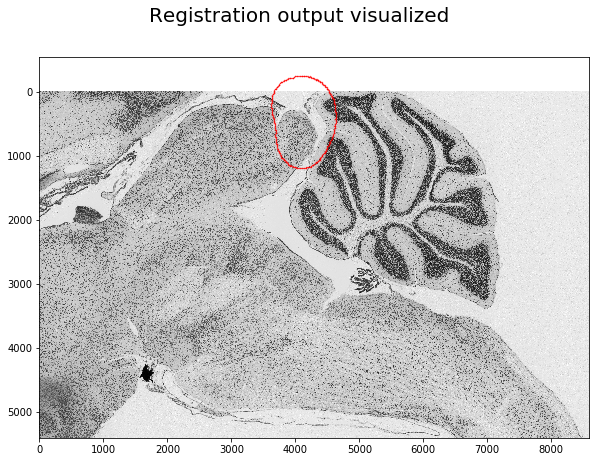

In [124]:
# rostral_limit = metadata_cache['cropbox'][stack][0] * 32.0/downsample
# dorsal_limit = metadata_cache['cropbox'][stack][2] * 32.0/downsample
rostral_limit = 0
dorsal_limit = 0
x_list = []
y_list = []

for [x,y] in moved_contours[section_viz]['12N'][0.5]:
    x_list.append(rostral_limit + x/downsample)
    y_list.append(dorsal_limit + y/downsample)

fig = plt.figure( figsize=(17,7) )
plt.imshow(img, cmap='gray', alpha=1)
plt.scatter(x_list,y_list, s=.1, color='r')

fig.suptitle('Registration output visualized', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# fig.savefig('test.jpg')
plt.show()

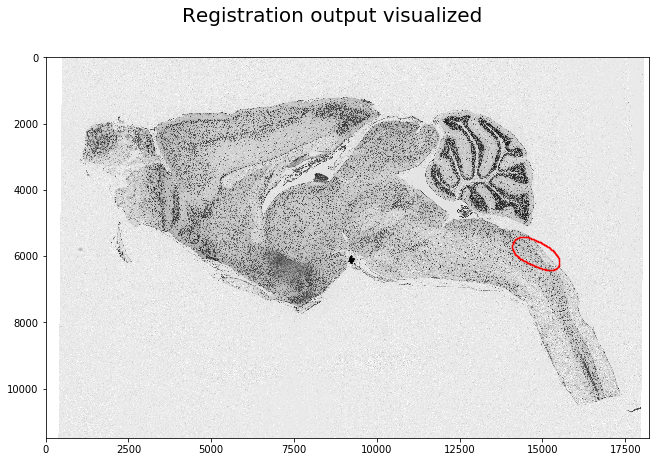

In [105]:
rostral_limit = metadata_cache['cropbox'][stack][0] * 32.0/downsample
dorsal_limit = metadata_cache['cropbox'][stack][2] * 32.0/downsample
x_list = []
y_list = []

for [x,y] in moved_contours[section_viz]['12N'][0.5]:
    x_list.append(rostral_limit + x/downsample)
    y_list.append(dorsal_limit + y/downsample)

fig = plt.figure( figsize=(17,7) )
plt.imshow(img, cmap='gray', alpha=1)
plt.scatter(x_list,y_list, s=.1, color='r')

fig.suptitle('Registration output visualized', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# fig.savefig('test.jpg')
plt.show()

In [63]:
! ls /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/MD585/

MD585_detector19_10.0um_scoreVolume
MD585_detector799_10.0um_scoreVolume
MD585_wholebrainWithMargin_10.0um_intensityVolume
